# **Smarter anomaly detection** - Post-processing back-test results
*Part 3 - Results post-processing*

## Initialization
---
This repository is structured as follow:

```sh
. smarter-anomaly-detection
|
├── data/
|   ├── interim                          # Temporary intermediate data are stored here
|   ├── processed                        # Finalized datasets ready to be moved to Amazon S3
|   └── raw                              # Immutable original data are stored here
|
└── notebooks/
    ├── 1_data_preparation.ipynb
    ├── 2_model_training.ipynb
    └── 3_model_evaluation.ipynb         <<< THIS NOTEBOOK <<<
```

### Notebook configuration update

In [1]:
!pip install --quiet --upgrade lookoutequipment

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.3.0 requires daal==2021.2.3, which is not installed.
numba 0.54.1 requires numpy<1.21,>=1.17, but you have numpy 1.22.3 which is incompatible.


### Imports

In [2]:
import boto3
import config
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sagemaker

from matplotlib.gridspec import GridSpec

# SDK / toolbox for managing Lookout for Equipment API calls:
import lookoutequipment as lookout

### Parameters

In [3]:
TMP_DATA       = os.path.join('..', 'data', 'interim')
PROCESSED_DATA = os.path.join('..', 'data', 'processed')
LABEL_DATA     = os.path.join(PROCESSED_DATA, 'label-data')
TRAIN_DATA     = os.path.join(PROCESSED_DATA, 'train-data', 'pump')

MODEL_NAME     = config.MODEL_NAME
DATASET_NAME   = config.DATASET_NAME
ROLE_ARN       = sagemaker.get_execution_role()

In [4]:
%matplotlib inline
plt.style.use('fivethirtyeight')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
plt.rcParams['lines.linewidth'] = 1.0

### Loading original datasets for visualization purpose

In [5]:
all_tags_fname = os.path.join(TRAIN_DATA, 'sensors.csv')
all_tags_df = pd.read_csv(all_tags_fname)
all_tags_df['Timestamp'] = pd.to_datetime(all_tags_df['Timestamp'])
all_tags_df = all_tags_df.set_index('Timestamp')

### Helper functions

In [6]:
def plot_ranges(range_df, range_title, color, ax):
    ax.plot(range_df['Label'], color=color)
    ax.fill_between(range_df.index, 
                    y1=range_df['Label'], 
                    y2=0, 
                    alpha=0.1, 
                    color=color)
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    ax.set_xlabel(range_title, fontsize=12)

## Extracting model back-test results
---

The [**DescribeModel**](https://docs.aws.amazon.com/lookout-for-equipment/latest/ug/API_DescribeModel.html) API can be used to extract, among other things, the metrics associated to the trained model. Here are the different fields available when calling this API:

In [7]:
lookout_dataset = lookout.LookoutEquipmentDataset(
    dataset_name=DATASET_NAME, 
    access_role_arn=ROLE_ARN,
    component_root_dir=TRAIN_DATA
)
response = lookout_dataset.client.describe_model(ModelName=MODEL_NAME)
training_start   = pd.to_datetime(response['TrainingDataStartTime']).tz_localize(None)
training_end     = pd.to_datetime(response['TrainingDataEndTime']).tz_localize(None)
evaluation_start = pd.to_datetime(response['EvaluationDataStartTime']).tz_localize(None)
evaluation_end   = pd.to_datetime(response['EvaluationDataEndTime']).tz_localize(None)

LookoutDiagnostics = lookout.LookoutEquipmentAnalysis(model_name=MODEL_NAME, tags_df=all_tags_df)
LookoutDiagnostics.set_time_periods(evaluation_start, evaluation_end, training_start, training_end)
predicted_ranges = LookoutDiagnostics.get_predictions()
labels_fname = os.path.join(LABEL_DATA, 'labels.csv')
labeled_range = LookoutDiagnostics.get_labels(labels_fname)

## Visualizing anomaly detection model results
---

Let's now display one of the original signal and map both the labeled and the predicted ranges on the same plot:

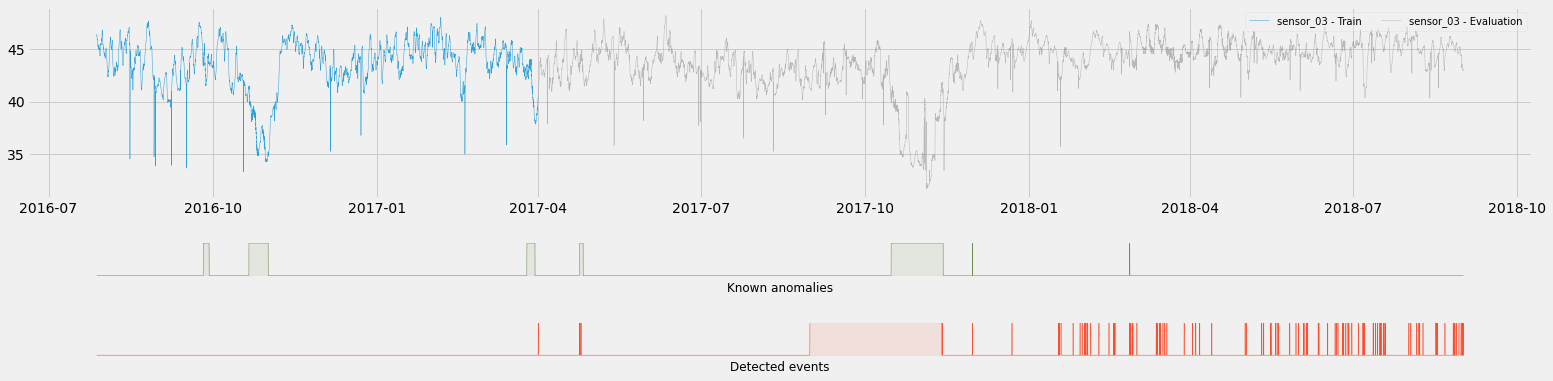

In [8]:
tags_list = list(all_tags_df.columns)
custom_colors = {
    'labels': colors[3],
    'predictions': colors[1]
}
    
TSViz = lookout.plot.TimeSeriesVisualization(
    timeseries_df=all_tags_df,
    data_format='tabular'
)
TSViz.add_signal([tags_list[3]])
TSViz.add_labels(labeled_range)
TSViz.add_predictions([predicted_ranges])
TSViz.add_train_test_split(evaluation_start)
TSViz.legend_format = {
    'loc': 'upper right',
    'framealpha': 0.4,
    'ncol': 2
}
fig, axis = TSViz.plot(fig_width=24, colors=custom_colors)

Let's zoom on the second part (the big event and some of the spikes happening afterward):

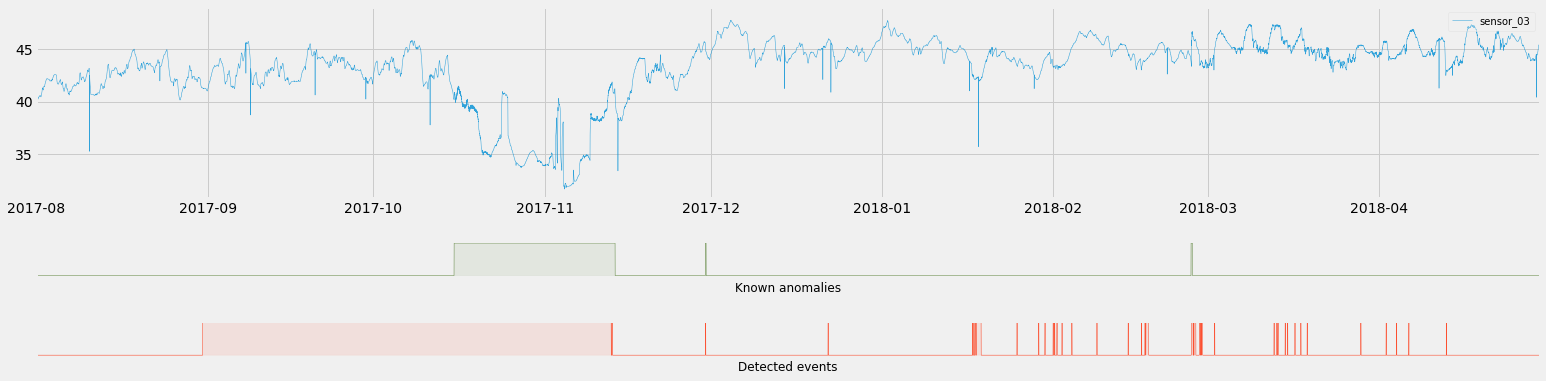

In [9]:
TSViz = lookout.plot.TimeSeriesVisualization(
    timeseries_df=all_tags_df,
    data_format='tabular'
)
TSViz.add_signal([tags_list[3]])
TSViz.add_labels(labeled_range)
TSViz.add_predictions([predicted_ranges])
TSViz.legend_format = {
    'loc': 'upper right',
    'framealpha': 0.4,
    'ncol': 2
}

fig, axis = TSViz.plot(fig_width=24, colors=custom_colors)
for ax in axis:
    ax.set_xlim(pd.to_datetime('2017-08-01'), pd.to_datetime('2018-04-30'))

The events are provided as ranges: to further post-process the results, we will need an expanded dataframe where each timestamp is marked as normal or abnormal:

In [10]:
predicted_ranges['duration'] = pd.to_datetime(predicted_ranges['end']) - pd.to_datetime(predicted_ranges['start'])
predicted_ranges['duration'] = predicted_ranges['duration'].dt.total_seconds() / 3600
predictions_df = TSViz._convert_ranges(predicted_ranges, default_freq='5min')
predicted_ranges

,start,end,diagnostics,duration
0,2017-04-01 00:39:00,2017-04-01 07:39:00,"[{'name': 'water-pump\sensor_00', 'value': 0.0...",7.000000
1,2017-04-24 01:59:00,2017-04-24 07:24:00,"[{'name': 'water-pump\sensor_00', 'value': 0.0...",5.416667
2,2017-04-24 08:29:00,2017-04-24 12:39:00,"[{'name': 'water-pump\sensor_00', 'value': 0.0...",4.166667
3,2017-04-24 23:34:00,2017-04-25 02:14:00,"[{'name': 'water-pump\sensor_00', 'value': 0.0...",2.666667
4,2017-08-31 02:24:00,2017-11-13 00:24:00,"[{'name': 'water-pump\sensor_00', 'value': 0.0...",1774.000000
...,...,...,...,...
106,2018-08-27 20:59:00,2018-08-28 00:39:00,"[{'name': 'water-pump\sensor_00', 'value': 0.0...",3.666667
107,2018-08-29 07:59:00,2018-08-30 00:14:00,"[{'name': 'water-pump\sensor_00', 'value': 0.0...",16.250000
108,2018-08-30 16:09:00,2018-08-30 20:49:00,"[{'name': 'water-pump\sensor_00', 'value': 0.0...",4.666667
109,2018-08-31 08:54:00,2018-08-31 12:29:00,"[{'name': 'water-pump\sensor_00', 'value': 0.0...",3.583333


Let's now expand the results to have one sensor per column in a dataframe:

In [11]:
expanded_results = []
for index, row in predicted_ranges.iterrows():
    new_row = dict()
    new_row.update({'start': row['start']})
    new_row.update({'end': row['end']})
    new_row.update({'prediction': 1.0})
    
    diagnostics = pd.DataFrame(row['diagnostics'])
    diagnostics = dict(zip(diagnostics['name'], diagnostics['value']))
    new_row = {**new_row, **diagnostics}
        
    expanded_results.append(new_row)
    
expanded_results = pd.DataFrame(expanded_results)

df_list = []
for index, row in expanded_results.iterrows():
    new_index = pd.date_range(start=row['start'], end=row['end'], freq='5T')
    new_df = pd.DataFrame(index=new_index)
    
    for tag in [t for t in tags_list]:
        new_df[tag] = row[f'water-pump\\{tag}']
        
    df_list.append(new_df)
    
expanded_results_v2 = pd.concat(df_list, axis='index')
expanded_results_v2 = expanded_results_v2.reindex(predictions_df.index)

freq = '1D'
expanded_results_v3 = expanded_results_v2.resample(freq).mean()
expanded_results_v3 = expanded_results_v3.replace(to_replace=np.nan, value=0.0)

expanded_results_v3.iloc[400:, :]

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51
2017-09-01,0.032218,0.021421,0.022863,0.013088,0.038291,0.030845,0.052896,0.060562,0.063985,0.065306,...,0.010075,0.012689,0.012814,0.014247,0.015100,0.012799,0.007728,0.008209,0.013995,0.203945
2017-09-02,0.032218,0.021421,0.022863,0.013088,0.038291,0.030845,0.052896,0.060562,0.063985,0.065306,...,0.010075,0.012689,0.012814,0.014247,0.015100,0.012799,0.007728,0.008209,0.013995,0.203945
2017-09-03,0.032218,0.021421,0.022863,0.013088,0.038291,0.030845,0.052896,0.060562,0.063985,0.065306,...,0.010075,0.012689,0.012814,0.014247,0.015100,0.012799,0.007728,0.008209,0.013995,0.203945
2017-09-04,0.032218,0.021421,0.022863,0.013088,0.038291,0.030845,0.052896,0.060562,0.063985,0.065306,...,0.010075,0.012689,0.012814,0.014247,0.015100,0.012799,0.007728,0.008209,0.013995,0.203945
2017-09-05,0.032218,0.021421,0.022863,0.013088,0.038291,0.030845,0.052896,0.060562,0.063985,0.065306,...,0.010075,0.012689,0.012814,0.014247,0.015100,0.012799,0.007728,0.008209,0.013995,0.203945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-27,0.028624,0.009042,0.017063,0.018369,0.028662,0.012220,0.047222,0.026465,0.027680,0.016589,...,0.013804,0.011681,0.034144,0.013587,0.005645,0.008696,0.039931,0.084854,0.214382,0.042631
2018-08-28,0.028477,0.009480,0.017044,0.018858,0.028676,0.011063,0.046989,0.026302,0.027525,0.016469,...,0.013961,0.011653,0.035386,0.014713,0.006048,0.008470,0.040962,0.085884,0.213287,0.043313
2018-08-29,0.028178,0.015476,0.016202,0.015766,0.027214,0.019191,0.045469,0.028322,0.022032,0.019555,...,0.006051,0.008322,0.059863,0.017273,0.004565,0.003791,0.044043,0.106014,0.206952,0.039044
2018-08-30,0.027794,0.015080,0.014403,0.012065,0.027797,0.014854,0.045647,0.032549,0.026560,0.020658,...,0.009091,0.012819,0.054749,0.018482,0.004205,0.005190,0.042712,0.084864,0.208048,0.031161


## Results post-processing
---
### Measuring event rates

In [13]:
plot_start = pd.to_datetime('2017-08-01')
plot_end = pd.to_datetime('2018-04-30')

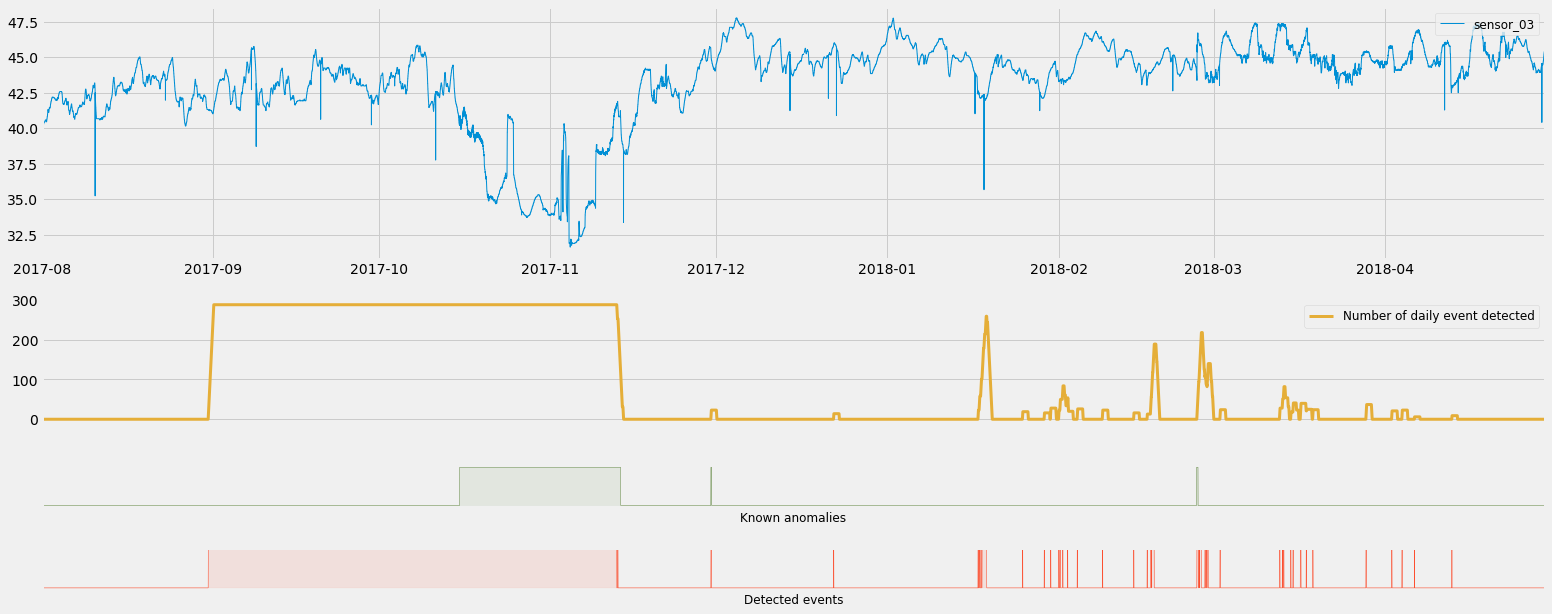

In [14]:
signal = 'sensor_03'
fig = plt.figure(figsize=(24,10))
gs = GridSpec(nrows=4, ncols=1, height_ratios=[0.6, 0.3, 0.1, 0.1], hspace=0.35)
df = expanded_results_v3.loc[plot_start:plot_end, :].copy()

ax0 = fig.add_subplot(gs[0])
ax0.plot(all_tags_df.loc[plot_start:plot_end, signal], color=colors[0], linewidth=1.0, label=signal)
ax0.legend(loc='upper right', fontsize=12)
ax0.set_xlim((plot_start, plot_end))

ax1 = fig.add_subplot(gs[1])
ax1.plot(predictions_df.rolling(12*24).sum(), label='Number of daily event detected', linewidth=3.0, color=colors[2])
ax1.legend(loc='upper right', fontsize=12)
ax1.set_xlim((plot_start, plot_end))
ax1.axes.get_xaxis().set_ticks([])

ax3 = fig.add_subplot(gs[2])
labels_df = TSViz._convert_ranges(labeled_range, default_freq='5min')
plot_ranges(labels_df, 'Known anomalies', colors[3], ax3)
ax3.set_xlim((plot_start, plot_end))

ax3 = fig.add_subplot(gs[3])
plot_ranges(predictions_df, 'Detected events', colors[1], ax3)
ax3.set_xlim((plot_start, plot_end))

plt.show()

### Measuring and plotting variables contributions

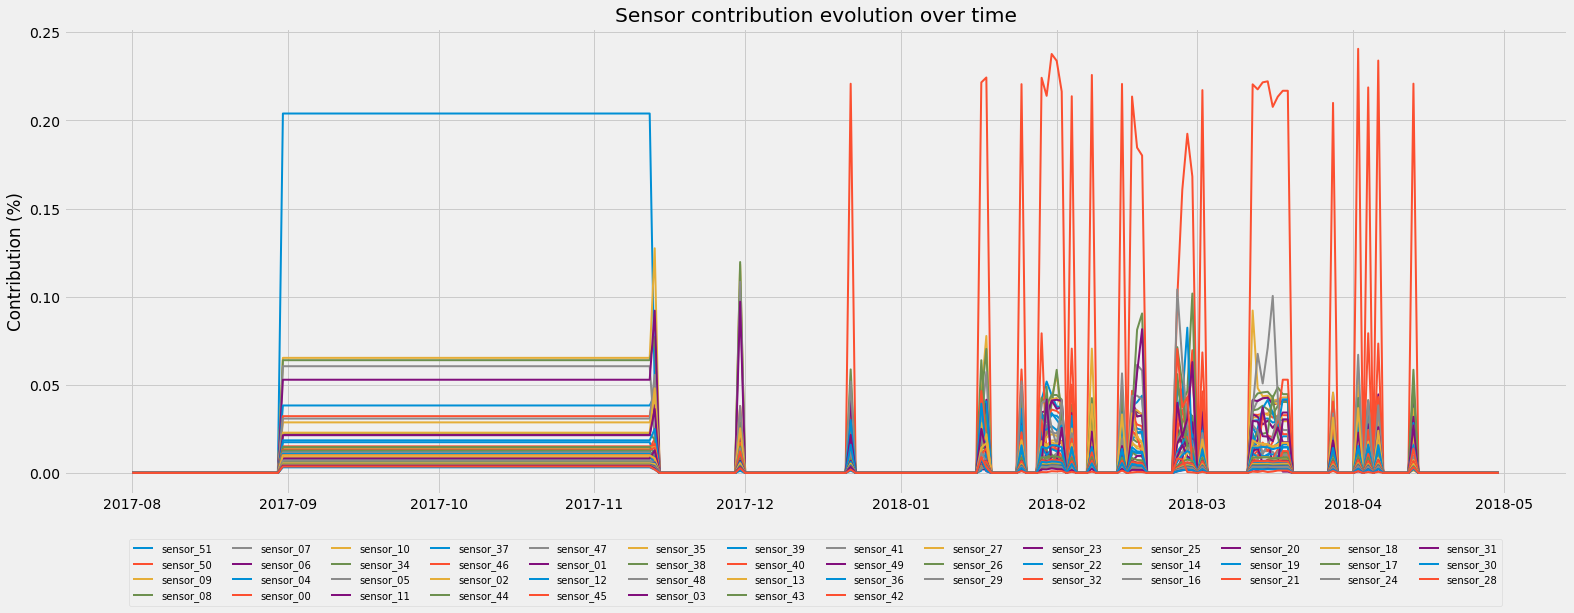

In [16]:
num_top_signals = 50
current_tags_list = list(df.sum().sort_values(ascending=False).head(num_top_signals).index)

fig = plt.figure(figsize=(24,8))
for tag in current_tags_list:
    plt.plot(df[tag], linewidth=2.0, label=tag)

plt.ylabel('Contribution (%)')
plt.title('Sensor contribution evolution over time')
plt.legend(loc='lower center', ncol=14, bbox_to_anchor=(0.5, -0.25))
plt.show()

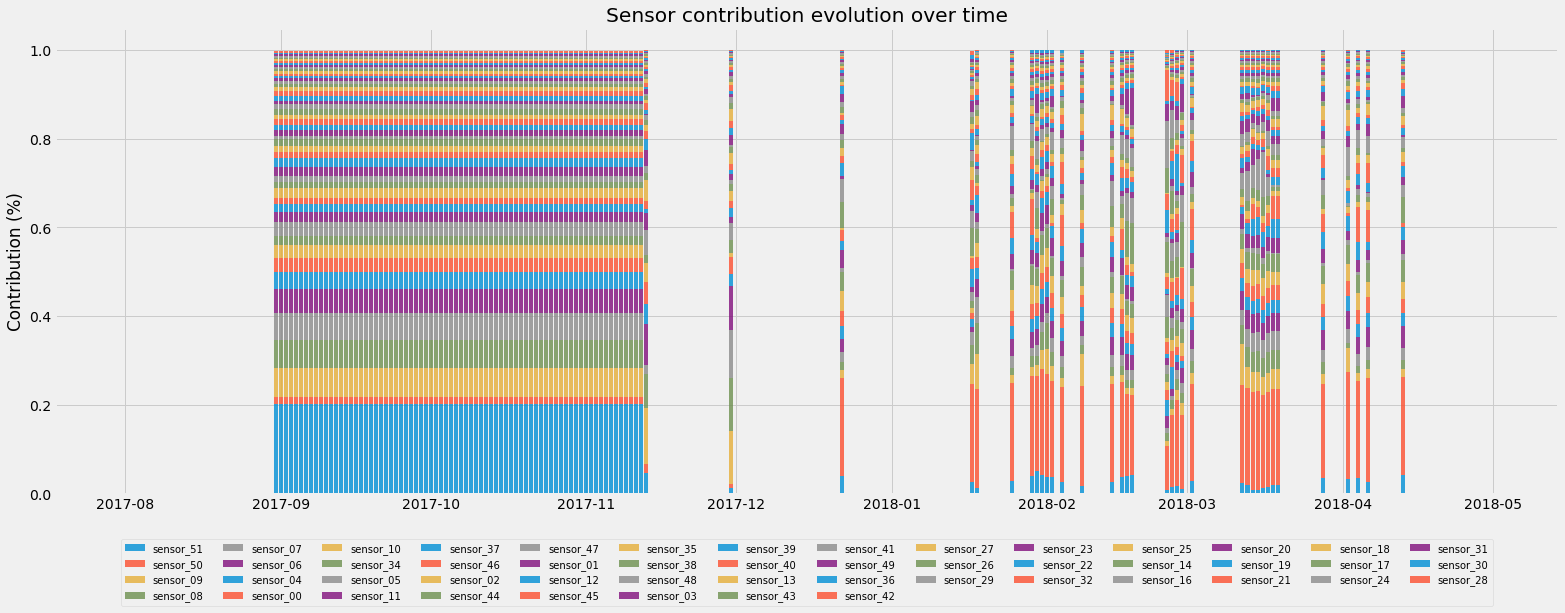

In [17]:
fig = plt.figure(figsize=(24,8))
bar_width = 0.8
bottom_values = np.zeros((len(df.index),))
for tag in current_tags_list:
    plt.bar(x=df.index, height=df[tag], bottom=bottom_values, alpha=0.8, width=bar_width, label=tag.split('\\')[0])
    bottom_values += df[tag].values

plt.ylabel('Contribution (%)')
plt.title('Sensor contribution evolution over time')
plt.legend(loc='lower center', ncol=14, bbox_to_anchor=(0.5, -0.25))
plt.show()

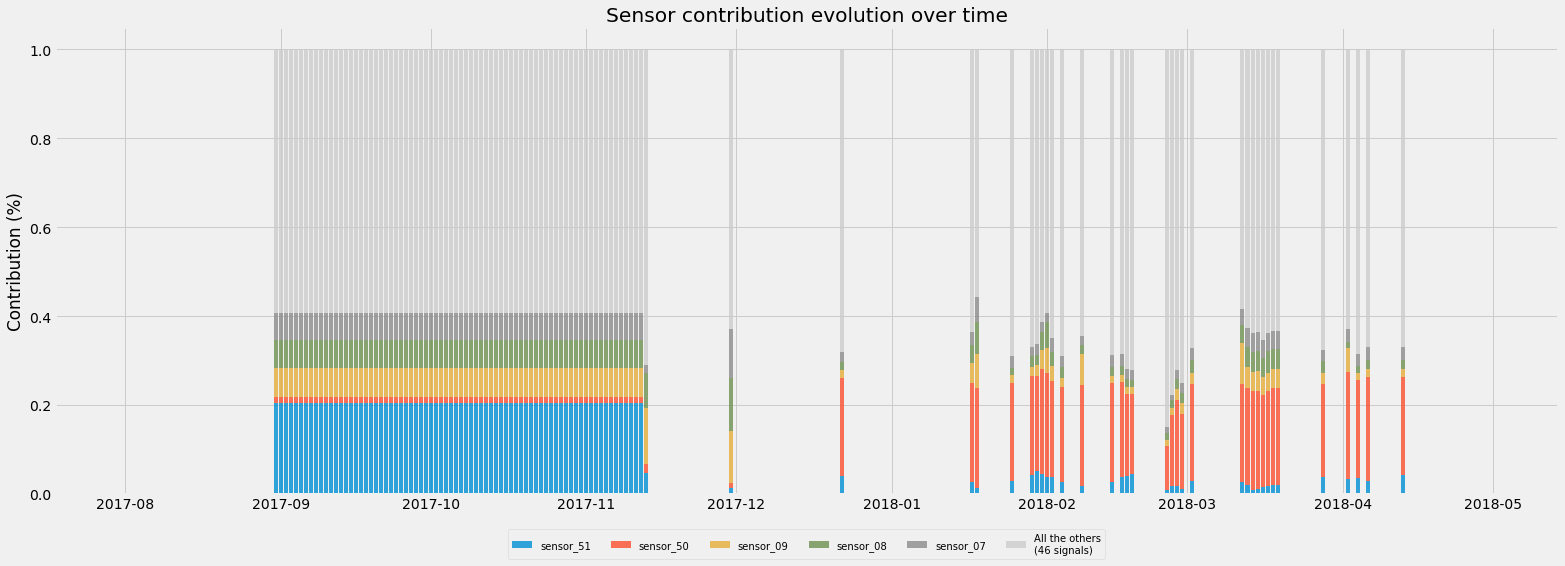

In [18]:
fig = plt.figure(figsize=(24,8))
num_top_signals = 5
bottom_values = np.zeros((len(df.index),))
current_tags_list = list(df.sum().sort_values(ascending=False).head(num_top_signals).index)
for tag in current_tags_list:
    plt.bar(x=df.index, height=df[tag], bottom=bottom_values, alpha=0.8, width=bar_width, label=tag.split('\\')[0])
    bottom_values += df[tag].values

all_other_tags = [t for t in df.columns if t not in current_tags_list]
all_other_tags_contrib = df[all_other_tags].sum(axis='columns')
plt.bar(x=df.index, height=all_other_tags_contrib, bottom=bottom_values, alpha=0.8, width=bar_width, label=f'All the others\n({len(all_other_tags)} signals)', color='#CCCCCC')

plt.ylabel('Contribution (%)')
plt.title('Sensor contribution evolution over time')
plt.legend(loc='lower center', ncol=14, bbox_to_anchor=(0.5, -0.15))
plt.show()

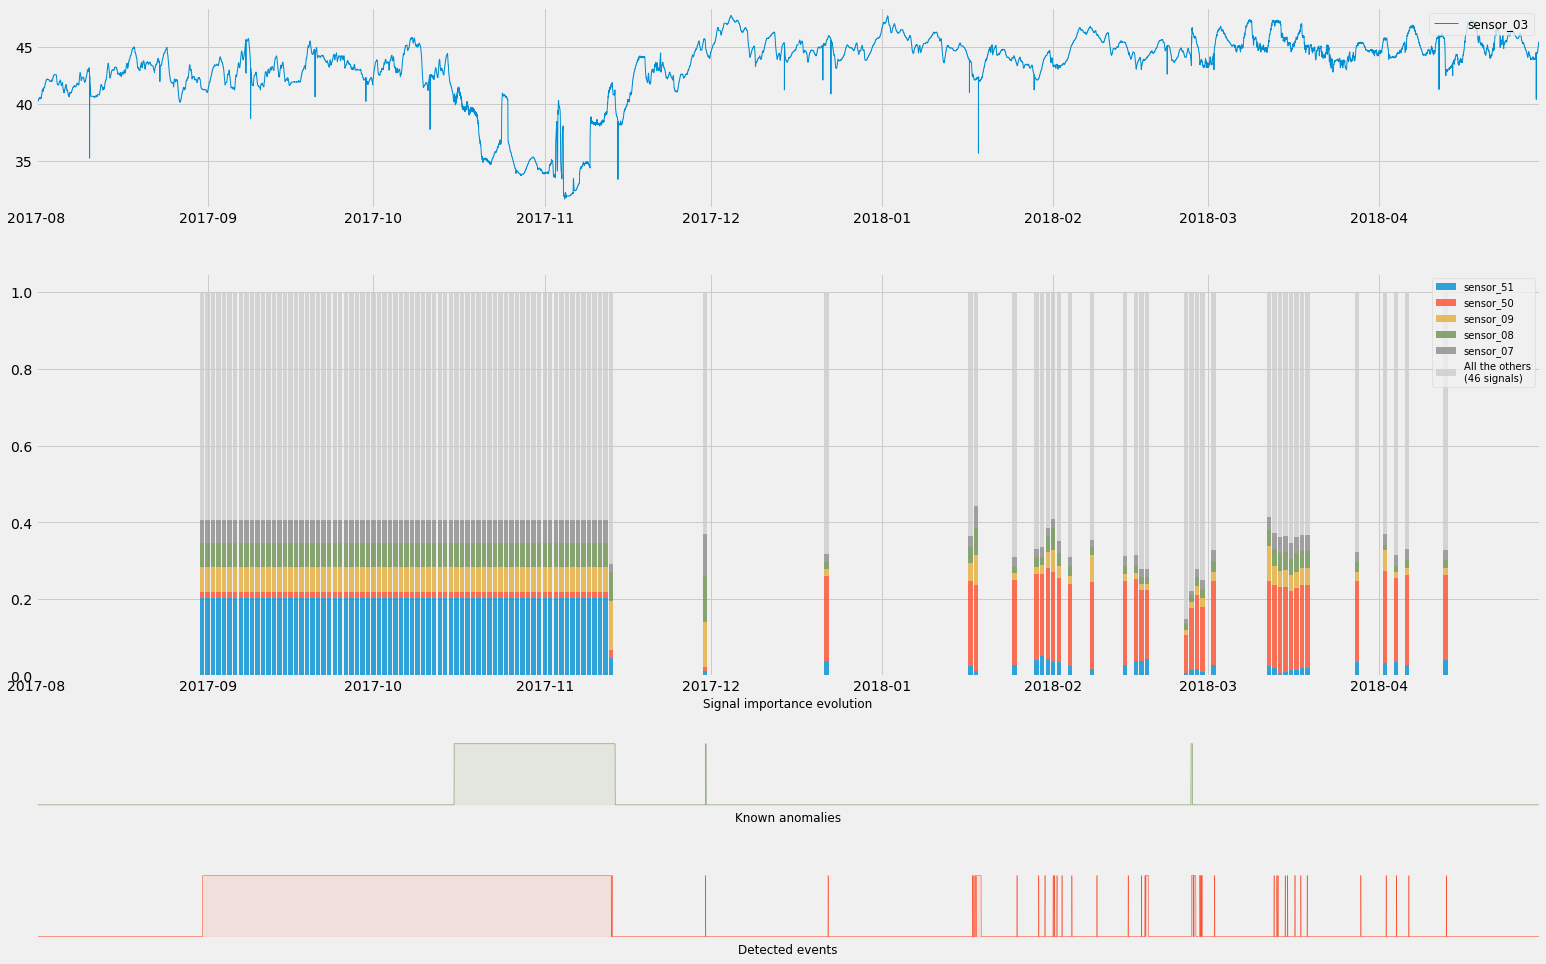

In [19]:
fig = plt.figure(figsize=(24,16))
gs = GridSpec(nrows=4, ncols=1, height_ratios=[0.3, 0.6, 0.1, 0.1], hspace=0.35)

ax0 = fig.add_subplot(gs[0])
ax0.plot(all_tags_df.loc[plot_start:plot_end, signal], color=colors[0], linewidth=1.0, label=signal)
ax0.legend(loc='upper right', fontsize=12)
ax0.set_xlim((plot_start, plot_end))

num_top_signals = 5
ax1 = fig.add_subplot(gs[1])
bottom_values = np.zeros((len(df.index),))
current_tags_list = list(df.sum().sort_values(ascending=False).head(num_top_signals).index)
for tag in current_tags_list:
    plt.bar(x=df.index, height=df[tag], bottom=bottom_values, alpha=0.8, width=bar_width, label=tag.split('\\')[0])
    bottom_values += df[tag].values

all_other_tags = [t for t in df.columns if t not in current_tags_list]
all_other_tags_contrib = df[all_other_tags].sum(axis='columns')
plt.bar(x=df.index, height=all_other_tags_contrib, bottom=bottom_values, alpha=0.8, width=bar_width, label=f'All the others\n({len(all_other_tags)} signals)', color='#CCCCCC')

ax1.legend(loc='upper right', ncol=1)
ax1.set_xlabel('Signal importance evolution', fontsize=12)
ax1.set_xlim((plot_start, plot_end))

ax2 = fig.add_subplot(gs[2])
labels_df = TSViz._convert_ranges(labeled_range, default_freq='5min')
plot_ranges(labels_df, 'Known anomalies', colors[3], ax2)
ax2.set_xlim((plot_start, plot_end))

ax3 = fig.add_subplot(gs[3])
plot_ranges(predictions_df, 'Detected events', colors[1], ax3)
ax3.set_xlim((plot_start, plot_end))

plt.show()

## Conclusion
---
In this notebook, you extracted the raw results from the anomaly detection model you trained previously and experimented with a few post-processing techniques to get more insights from your model results.